# IMPORT LIBRARIES

In [2]:
# HERE WE IMPORT ALL THE NECESSARIES LIBRARIES FOR OUR PROJECT

import pandas as pd
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns
import time
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# DATA IMPORT AND PREPARATION

## Data Import Process
The data was provided in a CSV file named SAdata_allMeasures.csv.  The Pandas library and Python were used to import the file into the Google Colab environment. In the following Steps.

1.   **Upload the Data File:** The Google Colab environment's file upload function was used to upload the CSV file.

2. **Load the Data:** The read_csv function was used to load the data into a Pandas DataFrame.

3. **Initial Data Exploration:** The initial few rows, shape, were printed to confirm that the dataset was loaded successfully.




In [6]:
# Load the dataset
file_path = '/content/drive/MyDrive/SAdata_allMeasures.csv'
data = pd.read_csv(file_path)


**DESCRIPTION OF THE DATASET**

There are 29 features (columns) and 1054 (rows) in the dataset, which includes both categorical and numerical variables. The dependent variable for prediction is represented by the target variable, Y.

**Overview of Features**
Numerical features are quantifiable values that include pupil changes, age, and time-based measurements.

*Numerical*: age, yearDriving, temp_length, temp_decisiontime, temp_correct_decision, pupilChange, pupilMean, pupilStd.

Categorical features are statistics that are based on groups, such as gender or choices.

Categorical: gender, temp_decision_made, CarPlacedLeft, CarPlacedRight.


In the  Original Shape before Preprocessing our data is
**Total rows: 1054**,
**Total columns: 29**
These 29 columns include both numerical and categorical features.

In [7]:
#Print the shape of data
print("Shape:", data.shape)

Shape: (1054, 29)


In [8]:
#Priting the first 5 elements of data
data.head()

,age,gender,yearDriving,drivingFrequency,temp_length,temp_decisiontime,temp_decision_made,temp_correct_decision,temp_danger,temp_difficulty,...,fMax,backMirror,leftMirror,rightMirror,road,sky,pupilChange,pupilMean,pupilStd,Y
0,26,1,20,1,12,4.80219,4,2,20,89,...,874.5,0,5,3,24,0,0.733955,3.818149,0.169227,0.641219
1,26,1,20,1,6,4.91667,1,2,10,99,...,1014.0,2,2,1,9,2,0.623622,3.743575,0.178412,0.354868
2,26,1,20,1,1,2.21716,2,2,99,99,...,259.5,0,0,0,3,0,0.205836,3.326857,0.079828,0.561225
3,26,1,20,1,3,2.63056,1,2,9,79,...,636.0,0,1,0,6,0,0.020505,3.643468,0.034005,0.422067
4,26,1,20,1,9,2.42632,1,2,9,96,...,807.0,5,4,1,13,0,0.632357,3.669544,0.196699,0.533333


FINDING MISSING VALUES:
The dataset is complete, with no missing values.

In [9]:
print("Missing Values:\n", data.isnull().sum())

Missing Values:
 age                      0
gender                   0
yearDriving              0
drivingFrequency         0
temp_length              0
temp_decisiontime        0
temp_decision_made       0
temp_correct_decision    0
temp_danger              0
temp_difficulty          0
CarPlacedLeft            0
CarPlacedRight           0
numS                     0
sAmpMean                 0
sAmpStd                  0
sAmpMax                  0
numF                     0
fMean                    0
fStd                     0
fMax                     0
backMirror               0
leftMirror               0
rightMirror              0
road                     0
sky                      0
pupilChange              0
pupilMean                0
pupilStd                 0
Y                        0
dtype: int64


#DATA PRE-PROCESSING

To prepare the data for machine learning algorithms, we used preprocessing techniques in this project. We specifically concentrated on employing one-hot encoding to handle categorical data while maintaining the integrity of numerical variables. The actions done during preprocessing are listed below:

**Step 1: Define Features and Target**
We started by defining the training features and the target variable (Y). The features are the input variables, and the target variable is the result we are attempting to predict.

**Step 2: Split the Data**
The dataset was divided into two parts: training and testing sets. The testing set was utilized to assess the model's performance, and the training set was utilized to train the model.

**Step 3: Preprocessing Pipeline**
Next, we created a preprocessing pipeline. The OneHotEncoder was used to handle categorical features by converting them into numerical representations. For the numerical features, no transformation was applied.

**Step 4: Apply Preprocessing and print Output**
After defining the pipeline, we applied it to both the training and testing datasets.
To make sure the preparation procedures were followed correctly and the data was prepared for training, we lastly printed the shapes of the converted datasets.



**Splitting the Data**
Train-test split divides the data into :
Training data:** 843 rows (80%)**
Testing data: **211 rows (20%)**

**After Preprocessing**
due to OneHotEncoding of categorical features  increase from **29 to 37** features, because it  creates additional binary columns for each unique category

**Justification for Preprocessing Choices**
Categorical Variables: One-hot encoding was chosen for categorical variables because it is effective for handling categories—it was selected for categorical variables.

Numerical Variables: Numerical features were left unchanged in this case, as they do not require further transformation.

In [10]:
# Define target and features
target_column = 'Y'  # The target variable
categorical_features = ['gender', 'temp_decision_made', 'CarPlacedLeft', 'CarPlacedRight']
numerical_features = [col for col in data.columns if col not in categorical_features + [target_column]]

X = data.drop(columns=[target_column])
y = data[target_column]

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing pipeline
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# ColumnTransformer applies OneHotEncoder to the categorical columns and leaves the numerical features untouched
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features) # Apply OneHotEncoder to categorical columns
    ], remainder='passthrough')  # Leave numerical features as they are

# Create a pipeline that applies the preprocessor
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Fit and Transform the training and test data
X_train_processed = pipeline.fit_transform(X_train)
X_test_processed = pipeline.transform(X_test)

#Print the Shape of the transformed datasets
print("Processed Training Shape:", X_train_processed.shape)
print("Processed Testing Shape:", X_test_processed.shape)


Processed Training Shape: (843, 37)
Processed Testing Shape: (211, 37)


VISUALIZE CORRELATION

Using the correlation heatmap that has been printed we can find some strong positive correlation and no negative correlations.

I chose not to eliminate any features despite the fact that some of them have been correlated because each one reflects distinct characteristics in the data. If a feature is removed, important information that could enhance model performance could be lost. In contrast, XGBoost and LightGBM are naturally able to handle correlated features and are robust to multicollinearity.

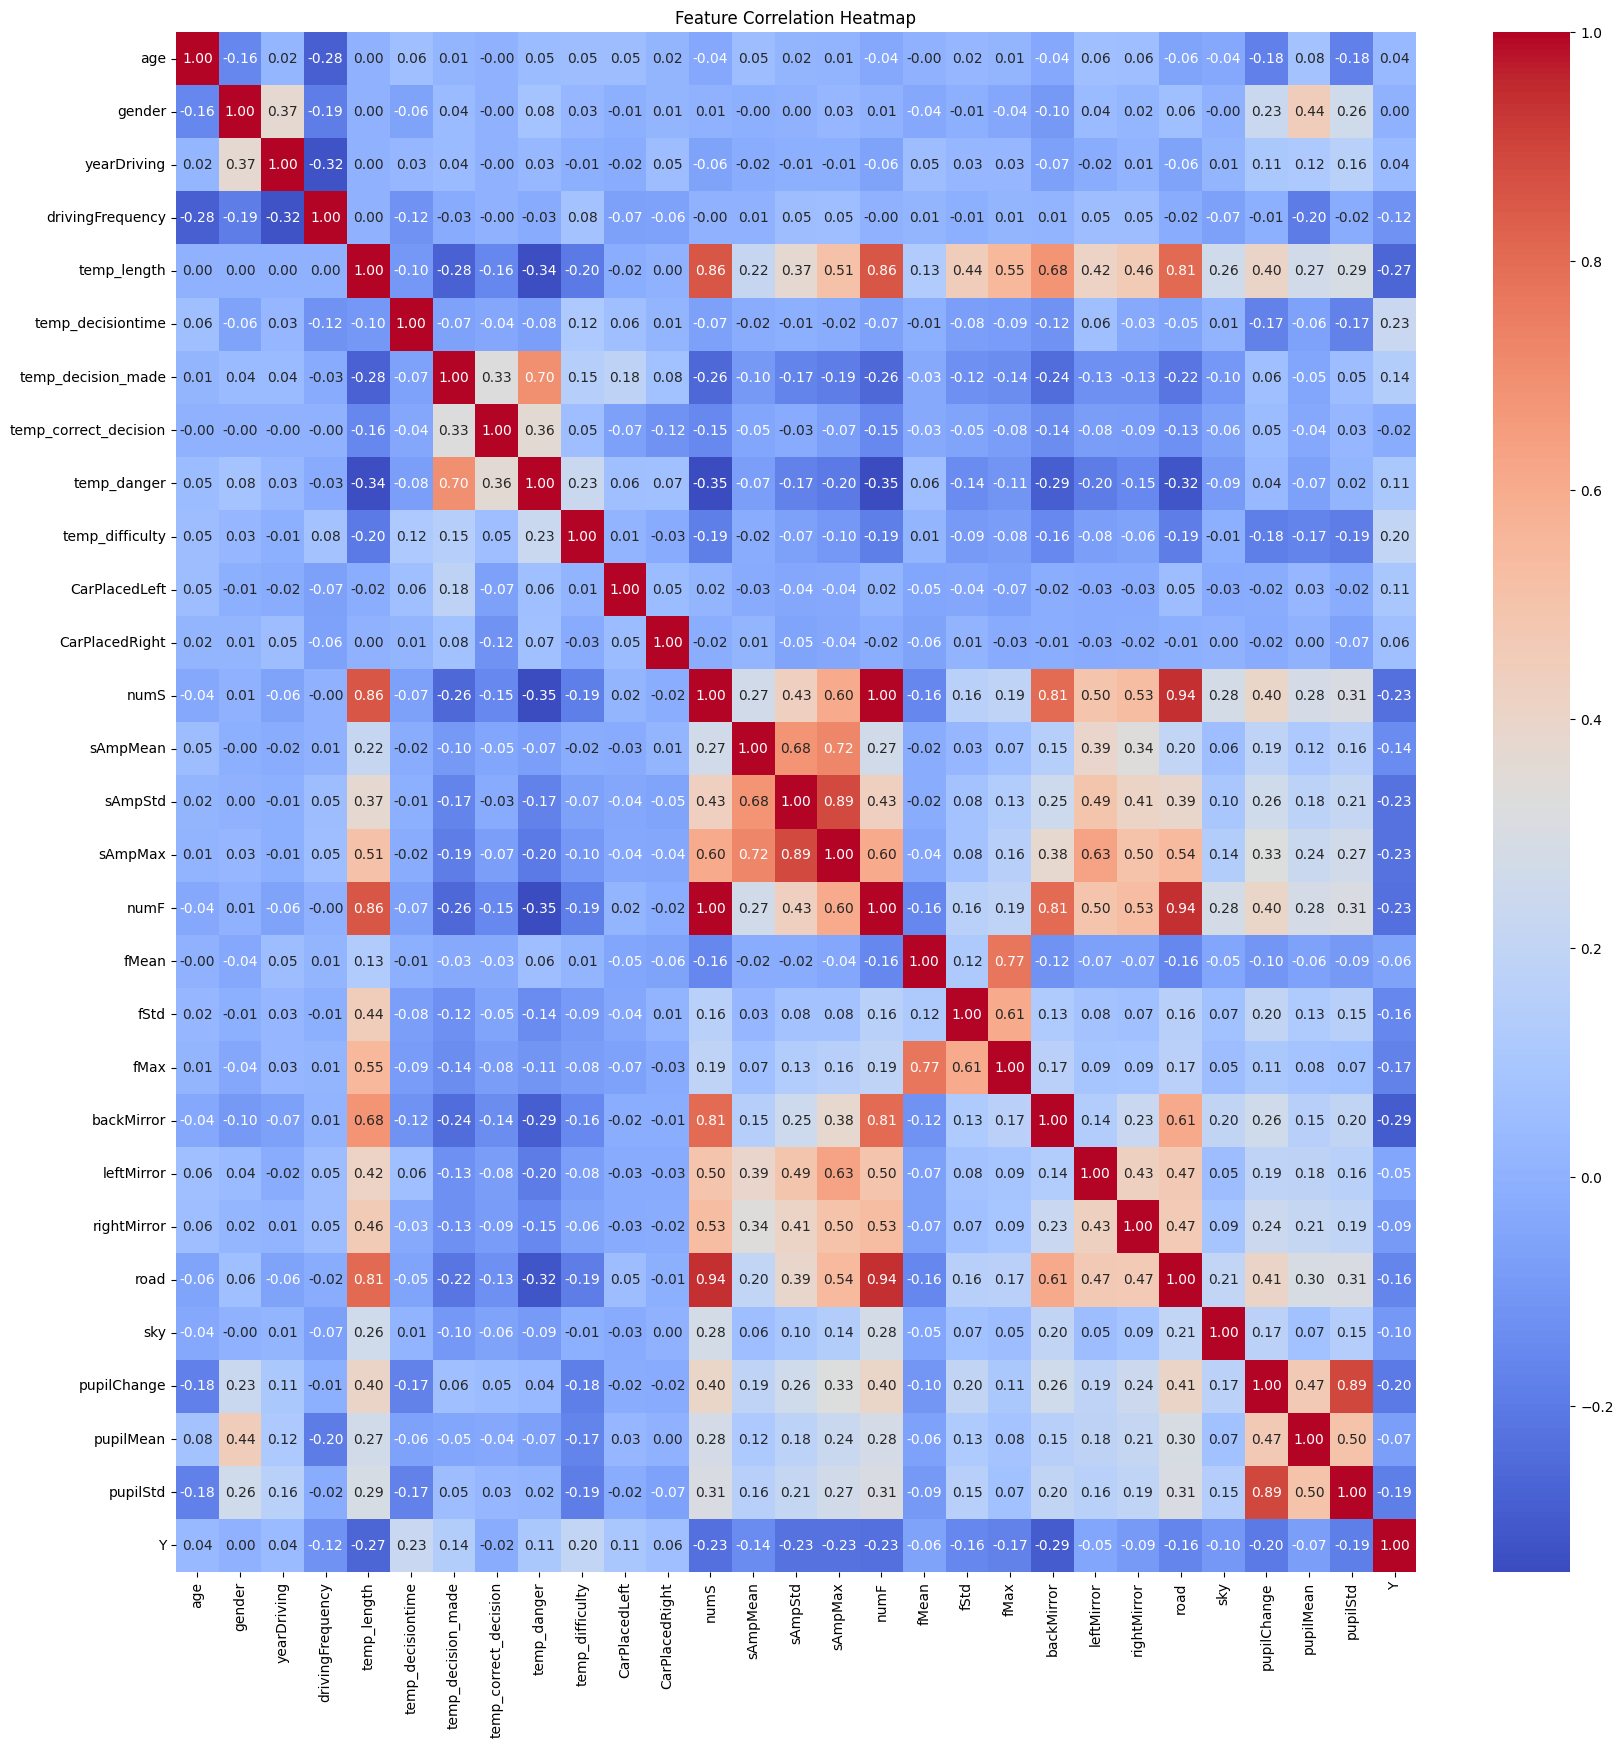

Highly Correlated Features:
             age  gender  yearDriving  drivingFrequency  temp_length  \
temp_length  NaN     NaN          NaN               NaN          NaN   
numS         NaN     NaN          NaN               NaN     0.856983   
sAmpStd      NaN     NaN          NaN               NaN          NaN   
sAmpMax      NaN     NaN          NaN               NaN          NaN   
numF         NaN     NaN          NaN               NaN     0.856983   
backMirror   NaN     NaN          NaN               NaN          NaN   
road         NaN     NaN          NaN               NaN     0.808631   
pupilChange  NaN     NaN          NaN               NaN          NaN   
pupilStd     NaN     NaN          NaN               NaN          NaN   

             temp_decisiontime  temp_decision_made  temp_correct_decision  \
temp_length                NaN                 NaN                    NaN   
numS                       NaN                 NaN                    NaN   
sAmpStd             

In [11]:
# Only select numerical features
numerical_data = data.select_dtypes(include=['float64', 'int64'])

# Compute the correlation matrix
correlation_matrix = numerical_data.corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Feature Correlation Heatmap")
plt.show()

# Identify highly correlated features (absolute value > 0.8)
high_correlation = correlation_matrix[(correlation_matrix > 0.8) & (correlation_matrix < 1.0)]
print("Highly Correlated Features:")
print(high_correlation.dropna(how='all'))

 # Implement XGBoost with Both RMSE, MAE, Training Time and Running Time

The first machine learning model we will use in this project is called XGBoost (Extreme Gradient Boosting), which is a potent gradient boosting-based machine learning technique. It excels in many kinds of classification and regression problems and is renowned for its scalability, flexibility, and efficiency.

Model Architecture
XGBoost works by building multiple decision trees in a sequential manner. Each new tree corrects the errors made by the previous ones, resulting in a strong ensemble model. The architecture includes:

**Objective**: We are using the reg:squarederror objective function for regression tasks.

Learning Rate: The learning rate is set to 0.1, which controls how much each tree contributes to the final prediction.

**Maximum Depth:** The depth of each tree is limited to 3 to prevent overfitting and ensure good generalization.

**Number of Estimators:** We trained the model for 100 trees (n_estimators = 100).

**Regularization Parameters:** We applied L2 regularization (reg_lambda) to prevent overfitting.

**Hyperparameters**
Here is the configuration used for training the XGBoost model the best values were found using GrdSearch:

objective: Defines the type of problem (regression).
colsample_bytree: Fraction of features used per tree (helps with generalization).
subsample: Fraction of samples used per tree.
learning_rate: Controls the step size at each iteration.
max_depth: Depth of each individual tree.
n_estimators: Number of trees to build.

**Training Model**
We trained the model using The train() method in XGBoost is used to train the model, passing the evaluation set and training dataset. To make sure the model is convergent, the training method involves tracking the performance measures (RMSE and MAE) at each iteration.

**Model Evaluation**
We evaluate the model using Root Mean Squared Error (RMSE) and Mean Absolute Error (MAE).

Visualizing the Results
To monitor the model’s convergence, we visualize the RMSE and MAE over the training iterations.We also display the Training and Running Time

**Evaluation of Model Performance**
Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE) were used to assess the performance of the XGBoost model after it was trained on the dataset. Plotting the training convergence above demonstrates that both the RMSE and MAE drastically dropped early in the training process, stabilizing about 50–60 cycles. This shows that learning and optimizing the model's parameters was successful.

**The following are the test set's final results:**
RMSE: 0.1052, indicating that the model's predictions, on average, deviate from actual values by about 0.1052 units. This is a good indicator of predictive accuracy.
MAE: 0.0828, demonstrating that the average absolute error between predicted and actual values is about 0.0828 units.
The model trained in 1.96 seconds, showcasing the efficiency of XGBoost in handling the given dataset. Moreover, the prediction time for new data was just 0.0017 seconds, reflecting the model's suitability for fast inference tasks.
Low error metrics and quick training and prediction timeframes indicate that the model is efficient and successful for the given regression job.

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:22:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Results:
Final RMSE on Test Set: 0.1052
Final MAE on Test Set: 0.0828
Training Time: 0.12 seconds
Running Time: 0.0020 seconds


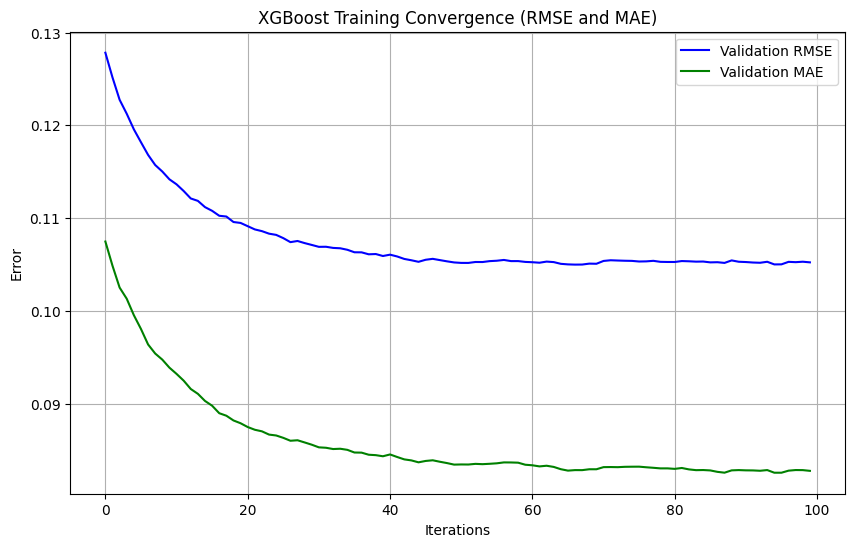

In [12]:
# Prepare the DMatrix for training and test set
dtrain = xgb.DMatrix(X_train_processed, label=y_train)
dtest = xgb.DMatrix(X_test_processed, label=y_test)

# Set XGBoost parameters
xgb_params = {
    'objective': 'reg:squarederror',
    'colsample_bytree': 0.7,
    'reg_lambda': 1,
    'subsample': 1.0,
    'learning_rate': 0.1,
    'max_depth': 3,
    'n_estimators': 100,
    'gamma': 0,
    'eval_metric': ['rmse', 'mae']  # Track both RMSE and MAE
}

# Create a dictionary to log metrics
evals_result_xgb = {}

# Track training time
start_train_time = time.time()

# Train the XGBoost model
xgb_model = xgb.train(
    params=xgb_params,
    dtrain=dtrain,
    num_boost_round=100,  # Number of iterations
    evals=[(dtrain, 'train'), (dtest, 'valid')],  # Evaluate on both train and test
    evals_result=evals_result_xgb,
    verbose_eval=False  # Set to True to see training progress
)

end_train_time = time.time()
training_time_xgb = end_train_time - start_train_time

# Extract RMSE and MAE for each iteration
validation_rmse_xgb = evals_result_xgb['valid']['rmse']
validation_mae_xgb = evals_result_xgb['valid']['mae']

# Predict on the test set and compute RMSE and MAE
start_run_time = time.time()
y_pred_xgb = xgb_model.predict(dtest)
end_run_time = time.time()
running_time_xgb = end_run_time - start_run_time

rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)

# Print final results
print("XGBoost Results:")
print(f"Final RMSE on Test Set: {rmse_xgb:.4f}")
print(f"Final MAE on Test Set: {mae_xgb:.4f}")
print(f"Training Time: {training_time_xgb:.2f} seconds")
print(f"Running Time: {running_time_xgb:.4f} seconds")

# Plot Validation RMSE and MAE over iterations
plt.figure(figsize=(10, 6))
plt.plot(validation_rmse_xgb, label='Validation RMSE', color='blue')
plt.plot(validation_mae_xgb, label='Validation MAE', color='green')
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.title('XGBoost Training Convergence (RMSE and MAE)')
plt.legend()
plt.grid(True)
plt.show()

**Training and Validation Loss**

The plot above shows the RMSE loss for both the training set (blue line) and the validation set (orange line) over 100 iterations. The model's performance improves during the initial iterations, with the training loss decreasing significantly. This indicates that the model is successfully learning from the training data.

However, after around 30-40 iterations, the validation loss stagnates, indicating that the model has reached a point where it no longer improves on the unseen validation data. The slight gap between the training loss and validation loss is typical, where the model tends to perform better on the training set compared to the validation set.

This pattern suggests that the model has effectively learned most of the patterns in the data, and further training may lead to overfitting.

In order to avoid overfitting and guarantee that the model performs well when applied to new data, early stopping could be used in practice to end the training process as soon as the validation loss stops getting better.

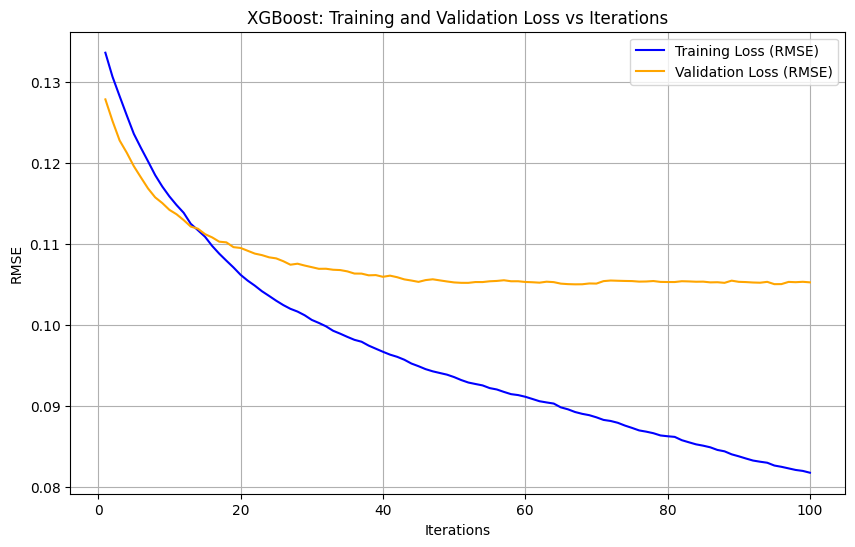

In [13]:
# Extract Metrics
train_loss = evals_result_xgb['train']['rmse']
valid_loss = evals_result_xgb['valid']['rmse']
iterations = np.arange(len(train_loss)) + 1

# Plot Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(iterations, train_loss, label='Training Loss (RMSE)', color='blue')
plt.plot(iterations, valid_loss, label='Validation Loss (RMSE)', color='orange')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('XGBoost: Training and Validation Loss vs Iterations')
plt.legend()
plt.grid()
plt.show()


# TUNING XGBOOST : GridSearch

In [15]:
#Tuning XGBOOST
# Define the parameter grid
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 6, 7],
    'n_estimators': [50, 100, 200],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'reg_lambda': [0, 0.1, 1]
}

# Initialize the XGBoost model
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

# GridSearchCV for XGBoost
grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
grid_search_xgb.fit(X_train_processed, y_train)

# Best parameters and best score
print("Best parameters for XGBoost:", grid_search_xgb.best_params_)
print("Best RMSE (negative MSE):", (-grid_search_xgb.best_score_)**0.5)

Fitting 5 folds for each of 5184 candidates, totalling 25920 fits
Best parameters for XGBoost: {'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'reg_lambda': 1, 'subsample': 1.0}
Best RMSE (negative MSE): 0.11174726073722746


#  Relationship Between RMSE and Hyperparameters

In [17]:
# Convert the GridSearchCV results into a DataFrame
results = pd.DataFrame(grid_search_xgb.cv_results_)

# Select relevant columns
results_summary = results[['param_learning_rate', 'param_max_depth',
                           'param_n_estimators', 'param_subsample',
                           'param_colsample_bytree', 'param_gamma',
                           'param_reg_lambda', 'mean_test_score']]

# Add RMSE column (convert negative MSE back to RMSE)
results_summary['RMSE'] = (-results_summary['mean_test_score'])**0.5

# Sort values for better visualization
results_summary = results_summary.sort_values(by='RMSE', ascending=True)

# Display the table
print(results_summary.head())

      param_learning_rate  param_max_depth  param_n_estimators  \
311                  0.10                3                 100   
179                  0.05                3                 200   
1906                 0.05                3                 200   
2039                 0.10                3                 100   
299                  0.10                3                  50   

      param_subsample  param_colsample_bytree  param_gamma  param_reg_lambda  \
311               1.0                     0.7          0.0               1.0   
179               1.0                     0.7          0.0               1.0   
1906              0.9                     0.8          0.0               1.0   
2039              1.0                     0.8          0.0               1.0   
299               1.0                     0.7          0.0               1.0   

      mean_test_score      RMSE  
311         -0.012487  0.111747  
179         -0.012496  0.111787  
1906        -0.01251

<ipython-input-17-acc7ef26f192>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_summary['RMSE'] = (-results_summary['mean_test_score'])**0.5


1. Plot RMSE vs learning_rate

The ideal learning rate for model training is approximately 0.025. By doing this, we may minimize error, avoid overfitting or instability during training, and make sure the model converges at the fastest possible rate.

Interpretation

The plot below shows the relationship between the learning rate and the mean RMSE (Root Mean Squared Error). Several important conclusions can be made by examining the plot:

Initial Sharp Decline: The RMSE begins to drop sharply, from about 0.121 to 0.117, at a learning rate of about 0.025. This implies that this learning rate leads to a significant improvement in the model's performance, suggesting that the rate promotes efficient learning and quicker convergence.

Steady RMSE Performance (0.05 to 0.125): The RMSE stabilizes as the learning rate rises from 0.05 to 0.125. The model's performance does not change significantly within this range, indicating that current learning rates enable the model to converge without producing appreciable errors.

Increase in RMSE with Higher Learning Rates: The RMSE starts to increase once more when the learning rate surpasses 0.125, reaching values of approximately 0.118 to 0.121. This suggests that the model finds it difficult to converge efficiently at greater learning rates, which could cause it to overshoot ideal values and perform worse.

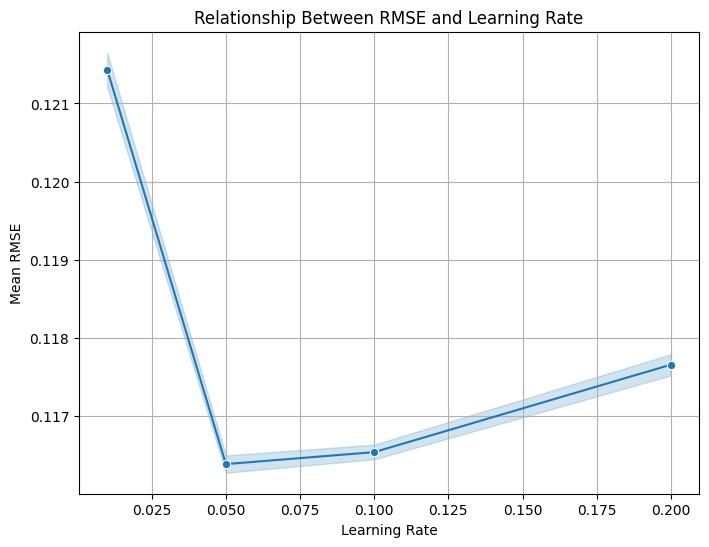

In [25]:
# Plot RMSE vs learning_rate
plt.figure(figsize=(8, 6))
sns.lineplot(data=results_summary, x='param_learning_rate', y='RMSE', marker='o')
plt.title('Relationship Between RMSE and Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Mean RMSE')
plt.grid()
plt.show()

2. Plot RMSE vs max_depth


The graph shows how the mean RMSE (Root Mean Squared Error) and the model's maximum depth—a parameter that controls tree depth—relate to one another. It is possible to find the ideal balance between underfitting and overfitting by examining how RMSE varies with maximum depth.

Implications for Model Tuning:

According to the findings, the optimal performance with the lowest RMSE is obtained when max depth = 3. Without overfitting the data, this depth enables the model to generalize effectively.
Because they result in increased RMSE, which indicates overfitting and decreased generalization ability, higher max depths (5 to 7) should be avoided.

Interpretation

Increasing RMSE with Max Depth: The plot indicates a consistent rise in RMSE from 3 to 7 as the maximum depth increases. This pattern suggests that permitting deeper trees results in a minor increase in error rather than better model performance.

Max Depth = 3 has the lowest RMSE: The RMSE is at its lowest (~0.1176) at max depth = 3. This shows that the model works best with a shallow tree, most likely because it finds a balance between overfitting and underfitting.

Performance Decline Beyond Depth = 3: Although the difference is slight, RMSE keeps increasing as max depth rises from 5 to 7. This trend suggests that the model may be overfitting due to deeper trees, catching noise in the data instead of general patterns

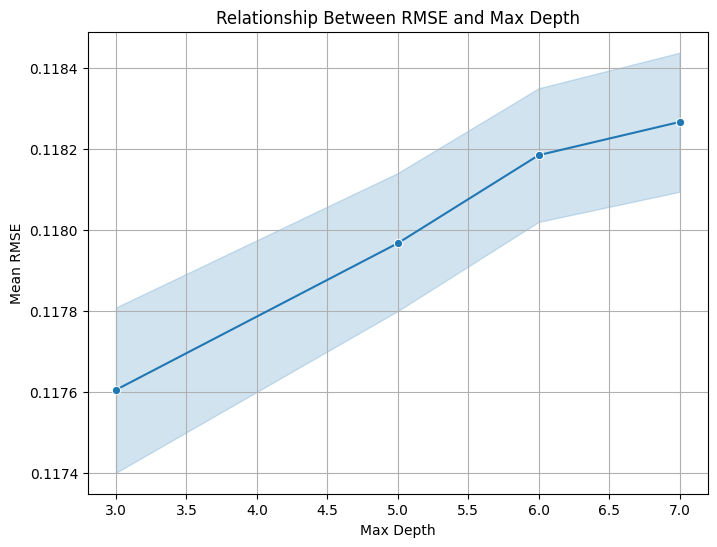

In [24]:
# Plot RMSE vs max_depth
plt.figure(figsize=(8, 6))
sns.lineplot(data=results_summary, x='param_max_depth', y='RMSE', marker='o')
plt.title('Relationship Between RMSE and Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('Mean RMSE')
plt.grid()
plt.show()


 Plot RMSE vs. n_estimators

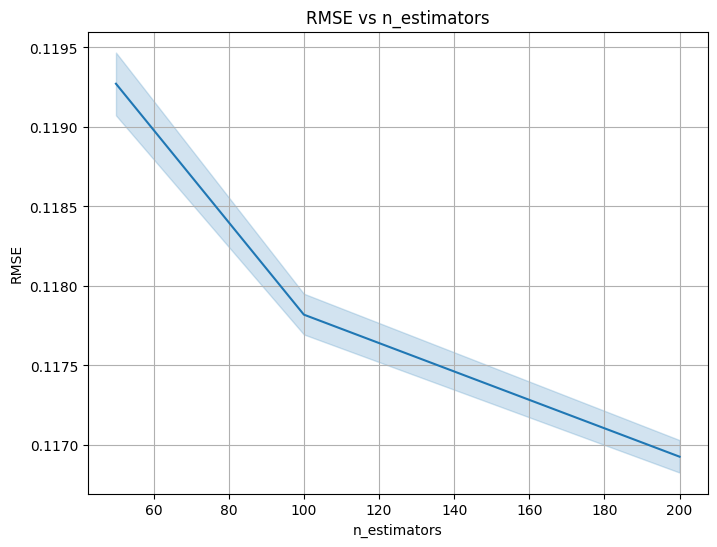

In [19]:
plt.figure(figsize=(8, 6))
sns.lineplot(x=results_summary['param_n_estimators'].astype(int),
             y=results_summary['RMSE'])
plt.title('RMSE vs n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('RMSE')
plt.grid()
plt.show()

Plot RMSE vs colsample_bytree

Colsample_bytree's Effect on Model Performance
The graph looks at the correlation between the Root Mean Squared Error (RMSE) and colsample_bytree, or the percentage of features utilized for training each tree.

Implications for Model Tuning:

Setting colsample_bytree = 0.8 yields slightly better performance with the lowest RMSE, making it a reasonable choice for training.
Since the RMSE remains stable for values beyond 0.8, using higher values (e.g., 0.9 or 1.0) does not degrade performance but does not improve it either.
Lower values (<0.8) can lead to slight increases in RMSE, potentially due to insufficient feature usage.


Important Points to Note:

Stability of RMSE Across colsample_bytree: As colsample_bytree rises from 0.7 to 1.0, the RMSE values are largely constant. The RMSE decreases very slightly up to 0.8, after which there is very little change.

At colsample_bytree = 0.8, the lowest RMSE: The RMSE reaches its lowest value (~0.118) at 0.8, indicating that the optimal model performance is achieved when 80% of the available features are used per tree.

Narrow Variation in RMSE: The model is intolerant to slight variations in the colsample_bytree parameter, as evidenced by the shaded confidence interval, which shows little variability over the range of colsample_bytree values.

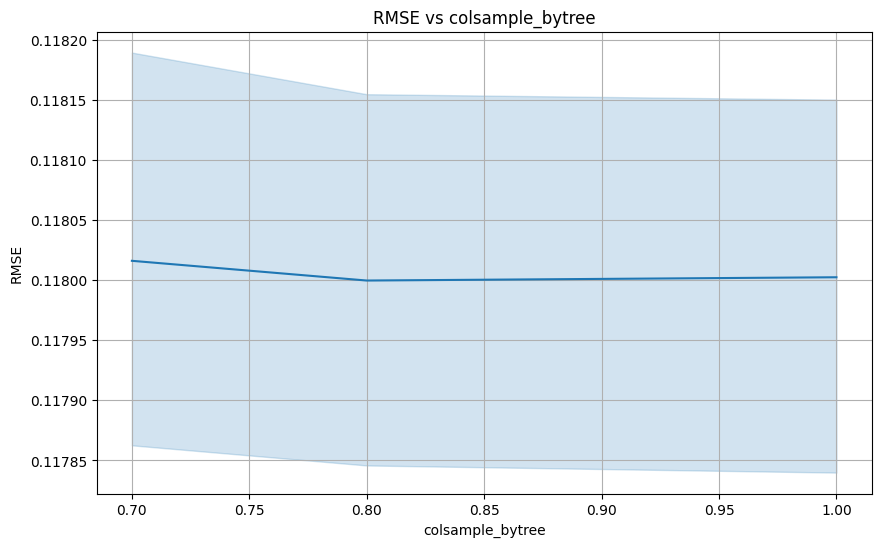

In [20]:
plt.figure(figsize=(10, 6))
sns.lineplot(x=results_summary['param_colsample_bytree'].astype(float),
             y=results_summary['RMSE'])
plt.title('RMSE vs colsample_bytree')
plt.xlabel('colsample_bytree')
plt.ylabel('RMSE')
plt.grid()
plt.show()

 Plot RMSE vs subsample

Subsample's Effect on Model Performance
The graph shows how the Root Mean Squared Error (RMSE) and the subsample parameter—the percentage of training data utilized for each boosting iteration—relate to one another. It is essential to modify this value in order to balance overfitting and performance.

Implications Model tuning: Subsample = 0.9 is the ideal setting since it offers the lowest RMSE with the least amount of variability.
A greater RMSE and more model instability, perhaps from overfitting, result from setting the subsample to 1.0.
While using smaller subsample values (such as 0.7–0.8) still yields competitive RMSE, training data may be underutilized.

Important Points to Note:
From 0.7 to 0.9, the RMSE continuously declines as the subsample grows, reaching its lowest RMSE at 0.9 (~0.1178).

When the subsample reaches 1.0, the RMSE rises substantially over 0.9, suggesting a possible loss of regularization.

0.9 is the lowest RMSE at the subsample. 90% of the training data should be used for each boosting iteration for the model to function at its best because this balances regularization and variance reduction.

High Variability at subsample = 1.0: Reflecting greater variability and possible overfitting when using the complete dataset, the shaded confidence interval greatly increases at subsample = 1.0.

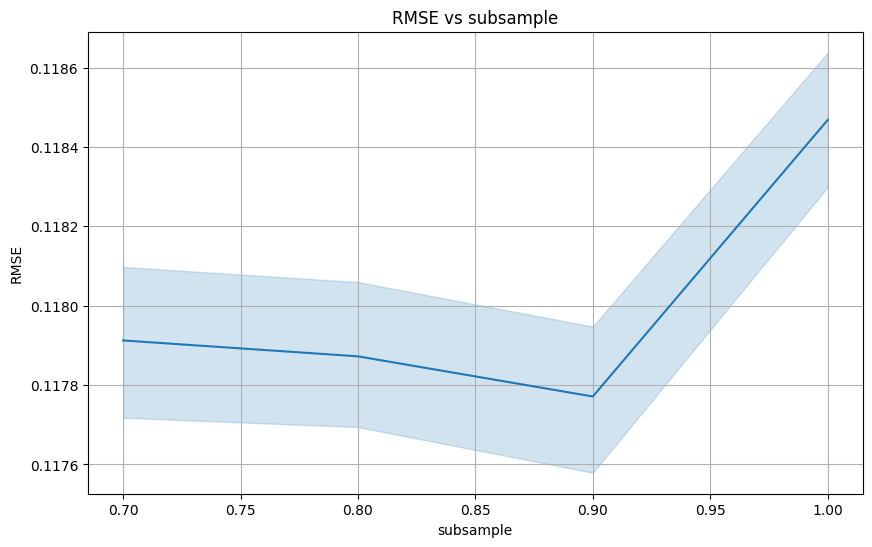

In [21]:
plt.figure(figsize=(10, 6))
sns.lineplot(x=results_summary['param_subsample'].astype(float),
             y=results_summary['RMSE'])
plt.title('RMSE vs subsample')
plt.xlabel('subsample')
plt.ylabel('RMSE')
plt.grid()
plt.show()

Heatmap of RMSE and the Hyperamaters

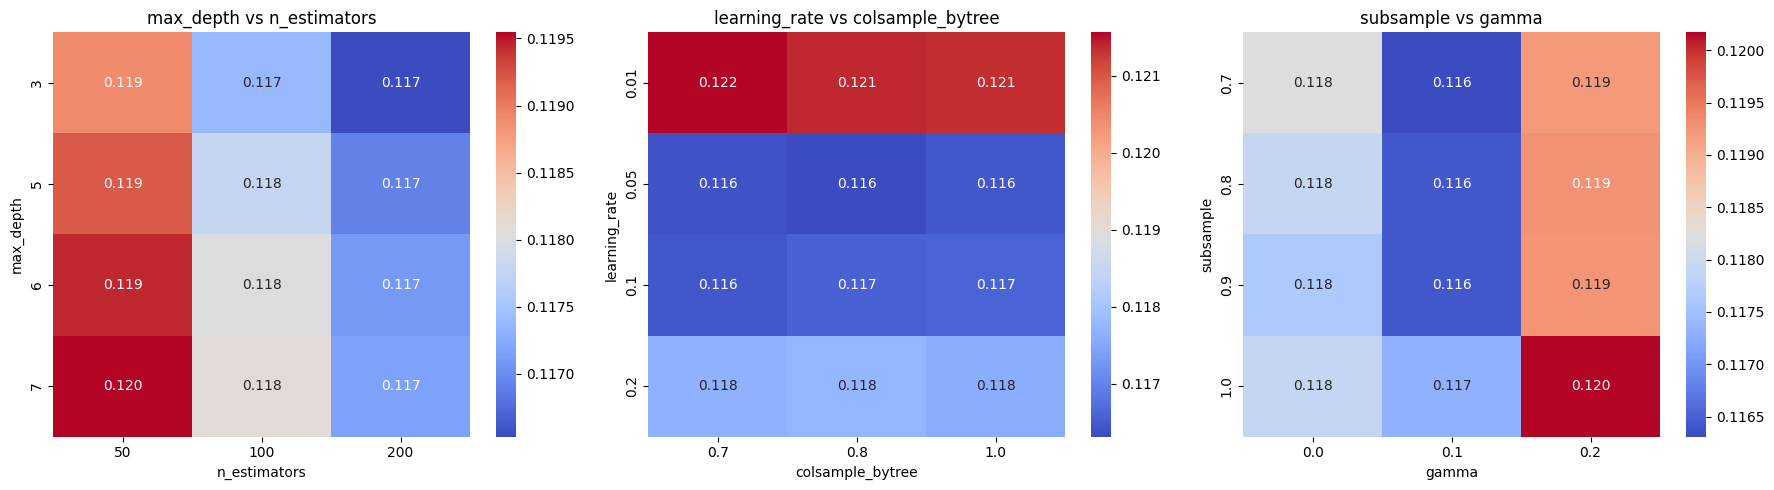

In [23]:
# Create pivot tables for each pair of hyperparameters
pivot_1 = results_summary.pivot_table(values='RMSE',
                                      index='param_max_depth',
                                      columns='param_n_estimators')
pivot_2 = results_summary.pivot_table(values='RMSE',
                                      index='param_learning_rate',
                                      columns='param_colsample_bytree')
pivot_3 = results_summary.pivot_table(values='RMSE',
                                      index='param_subsample',
                                      columns='param_gamma')

# Plot multiple heatmaps in subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Heatmap 1: max_depth vs n_estimators
sns.heatmap(pivot_1, annot=True, fmt=".3f", cmap="coolwarm", ax=axes[0])
axes[0].set_title("max_depth vs n_estimators")
axes[0].set_xlabel("n_estimators")
axes[0].set_ylabel("max_depth")

# Heatmap 2: learning_rate vs colsample_bytree
sns.heatmap(pivot_2, annot=True, fmt=".3f", cmap="coolwarm", ax=axes[1])
axes[1].set_title("learning_rate vs colsample_bytree")
axes[1].set_xlabel("colsample_bytree")
axes[1].set_ylabel("learning_rate")

# Heatmap 3: subsample vs gamma
sns.heatmap(pivot_3, annot=True, fmt=".3f", cmap="coolwarm", ax=axes[2])
axes[2].set_title("subsample vs gamma")
axes[2].set_xlabel("gamma")
axes[2].set_ylabel("subsample")

plt.tight_layout()
plt.show()

# XGBOOST CROSS VALIDATION

Conclusion:

"The 10-fold cross-validation results indicate that the XGBoost Regressor achieved a mean RMSE of 0.1114 and a mean MAE of 0.0869, demonstrating reliable and consistent performance. The results suggest that this model is suitable for further deployment or comparison with other models.

In [21]:
from sklearn.model_selection import cross_val_score

# Initialize XGBoost regressor
xgb_cv_model = xgb.XGBRegressor(
    booster='gbtree',
    objective='reg:squarederror',
    learning_rate=0.1,
    max_depth=3,
    n_estimators=100,
    random_state=42
)


# Perform 10-fold cross-validation for RMSE
rmse_scores_xgb = cross_val_score(
    xgb_cv_model, X_train_processed, y_train,
    cv=10, scoring='neg_mean_squared_error'
)
mean_rmse_xgb = np.sqrt(-rmse_scores_xgb).mean()

# Perform 10-fold cross-validation for MAE
mae_scores_xgb = cross_val_score(
    xgb_cv_model, X_train_processed, y_train,
    cv=10, scoring='neg_mean_absolute_error'
)
mean_mae_xgb = -mae_scores_xgb.mean()

print(f"Mean RMSE (XGBoost): {mean_rmse_xgb}")
print(f"Mean MAE (XGBoost): {mean_mae_xgb}")

Mean RMSE (XGBoost): 0.11135408192856389
Mean MAE (XGBoost): 0.08692054886273477


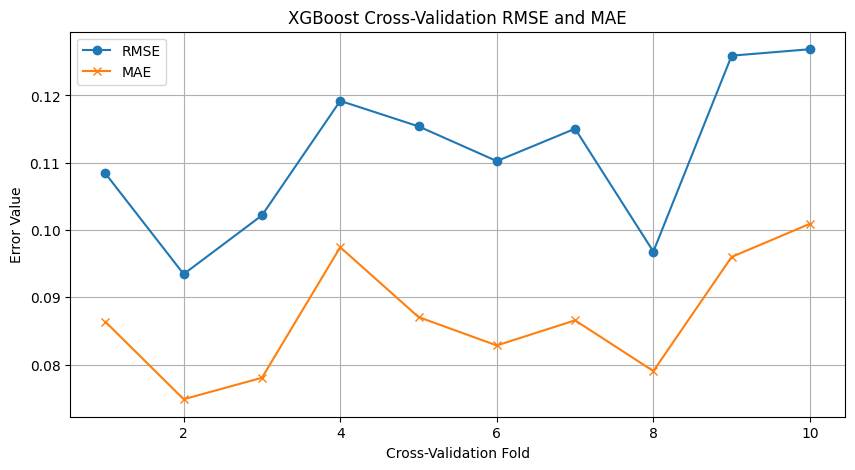

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# RMSE and MAE fold scores
rmse_fold_scores = np.sqrt(-rmse_scores_xgb)
mae_fold_scores = -mae_scores_xgb

# Plot RMSE
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), rmse_fold_scores, marker='o', label='RMSE')
plt.plot(range(1, 11), mae_fold_scores, marker='x', label='MAE')
plt.xlabel('Cross-Validation Fold')
plt.ylabel('Error Value')
plt.title('XGBoost Cross-Validation RMSE and MAE')
plt.legend()
plt.grid(True)
plt.show()


# XGBOOST FINAL MODEL EVALUATION ON TEST SET

In [28]:
# XGBoost Predictions
# Reset X_train_processed and X_test_processed using the original train_test_split
X_train_processed = pipeline.fit_transform(X_train)
X_test_processed = pipeline.transform(X_test)

# Recreate the DMatrix for training and test set with the correct data
dtrain = xgb.DMatrix(X_train_processed, label=y_train)
dtest = xgb.DMatrix(X_test_processed, label=y_test)

xgb_model_final = xgb.train(
    params=xgb_params,
    dtrain=dtrain,
    num_boost_round=100
)
xgb_predictions = xgb_model_final.predict(dtest)

# Evaluate XGBoost
xgb_rmse_test = np.sqrt(mean_squared_error(y_test, xgb_predictions))
xgb_mae_test = mean_absolute_error(y_test, xgb_predictions)
print("XGBoost Test RMSE:", xgb_rmse_test)
print("XGBoost Test MAE:", xgb_mae_test)

XGBoost Test RMSE: 0.10523684738875577
XGBoost Test MAE: 0.08276496600086442


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:22:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


#IMPLEMENT LIGHTGBM (DISTRIBUTED)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000443 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2906
[LightGBM] [Info] Number of data points in the train set: 843, number of used features: 35
[LightGBM] [Info] Start training from score 0.286042
Training Time: 0.12 seconds
Running (Prediction) Time: 0.00 seconds
RMSE: 0.1053
MAE: 0.0816


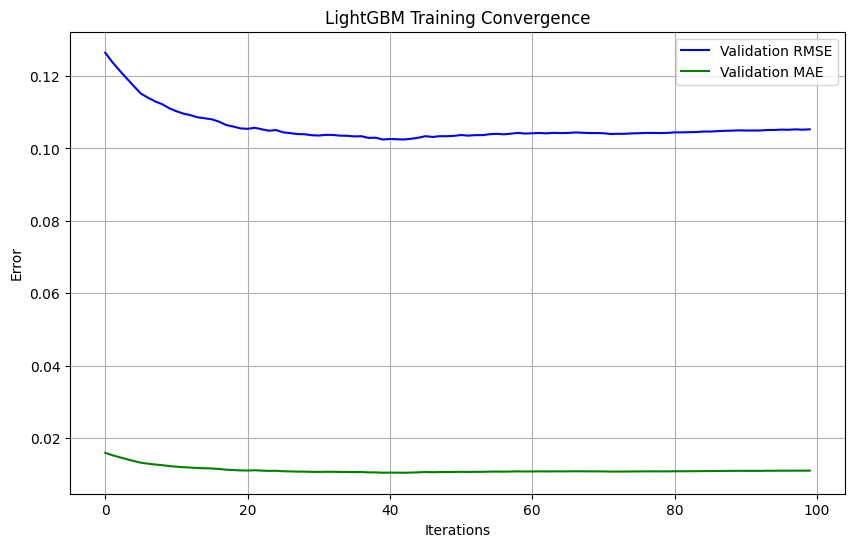

In [17]:
# Set LightGBM parameters
lgb_params = {
    'objective': 'regression',
    'metric': ['rmse', 'l2'],
    'learning_rate': 0.1,
    'num_leaves': 20,
    'random_state': 42
}

# Track training time
start_train_time = time.time()

# Train LightGBM model
train_data = lgb.Dataset(X_train_processed, label=y_train)
test_data = lgb.Dataset(X_test_processed, label=y_test, reference=train_data)
evals_result_lgb = {}
model = lgb.train(lgb_params,
                  train_data,
                  num_boost_round=100,
                  valid_sets=[train_data, test_data],  # valid_sets argument

                  valid_names=['train', 'eval'],         # This is necessary for the key 'eval' to be created in evals_result_lgb
                  callbacks=[lgb.record_evaluation(evals_result_lgb)]
                                )

end_train_time = time.time()
training_time = end_train_time - start_train_time

print(f"Training Time: {training_time:.2f} seconds")

# Track running (inference) time
start_run_time = time.time()
y_pred = model.predict(X_test_processed[:len(y_test)], num_iteration=model.best_iteration) # Slice X_test_processed to match y_test length
end_run_time = time.time()
running_time = end_run_time - start_run_time

print(f"Running (Prediction) Time: {running_time:.2f} seconds")

# Evaluate the model performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")


# Extract RMSE and MAE for each iteration
validation_rmse_lgb = evals_result_lgb['eval']['rmse']
validation_mae_lgb = evals_result_lgb['eval']['l2']


# Plot Validation RMSE and MAE over iterations for LightGBM
plt.figure(figsize=(10, 6))
plt.plot(validation_rmse_lgb, label='Validation RMSE', color='blue')
plt.plot(validation_mae_lgb, label='Validation MAE', color='green')
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.title('LightGBM Training Convergence')
plt.legend()
plt.grid(True)
plt.show()

TRAINING LOSS

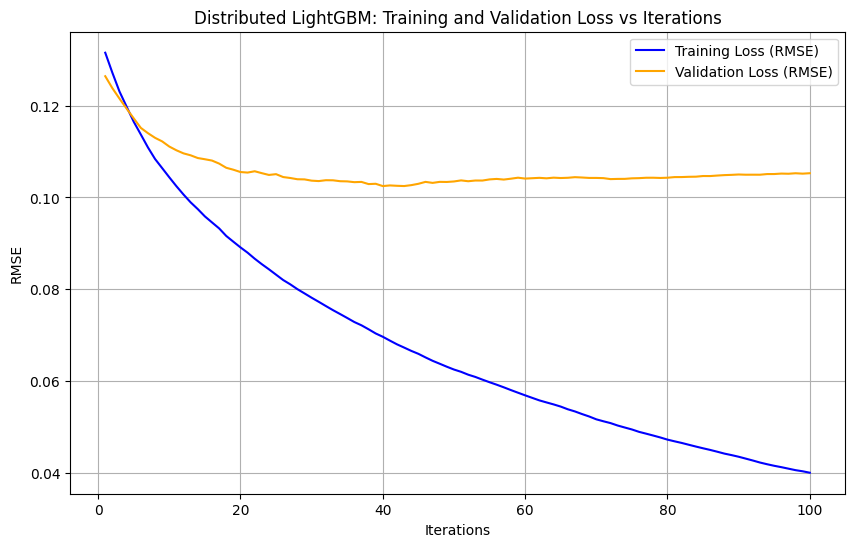

In [19]:
# Extract Metrics
train_loss = evals_result_lgb['train']['rmse']
valid_loss = evals_result_lgb['eval']['rmse']
iterations = np.arange(len(train_loss)) + 1

# Plot Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(iterations, train_loss, label='Training Loss (RMSE)', color='blue')
plt.plot(iterations, valid_loss, label='Validation Loss (RMSE)', color='orange')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Distributed LightGBM: Training and Validation Loss vs Iterations')
plt.legend()
plt.grid()
plt.show()

# Lightgbm RandomizedSearchCV

In [ ]:
# Use the same parameter grid
param_dist_lgb = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'num_leaves': [20, 31, 50, 70],
    'max_depth': [3, 5, 7, -1],
    'n_estimators': [50, 100, 200],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'reg_lambda': [0, 0.1, 1],
    'reg_alpha': [0, 0.1, 1],
    'min_child_samples': [10, 20, 30]
}

# Initialize LightGBM model
lgb_model = lgb.LGBMRegressor(objective='regression', random_state=42)

# RandomizedSearchCV for LightGBM
random_search_lgb = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=param_dist_lgb,
    n_iter=50,  # Limit to 50 random combinations
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Fit the model
random_search_lgb.fit(X_train_processed, y_train)

# Best parameters and score
print("Best parameters for LightGBM:", random_search_lgb.best_params_)
print("Best RMSE (negative MSE):", (-random_search_lgb.best_score_)**0.5)

#Lightgbm Cross Validation

In [22]:
# Initialize LightGBM regressor
lgb_cv_model = lgb.LGBMRegressor(
    objective='regression',
    learning_rate=0.1,
    num_leaves=20,
    random_state=42,
    verbose=-1
)
X_train_processed = X_train_processed[:len(y_train)]  # Adjust X_train_processed to match y_train's length
# Perform 10-fold cross-validation for RMSE
rmse_scores_lgb = cross_val_score(
    lgb_cv_model, X_train_processed, y_train,
    cv=10, scoring='neg_mean_squared_error'
)
mean_rmse_lgb = np.sqrt(-rmse_scores_lgb).mean()

# Perform 10-fold cross-validation for MAE
mae_scores_lgb = cross_val_score(
    lgb_cv_model, X_train_processed, y_train,
    cv=10, scoring='neg_mean_absolute_error'
)
mean_mae_lgb = -mae_scores_lgb.mean()

print(f"Mean RMSE (LightGBM): {mean_rmse_lgb}")
print(f"Mean MAE (LightGBM): {mean_mae_lgb}")

Mean RMSE (LightGBM): 0.11575727893094645
Mean MAE (LightGBM): 0.08994972101115997


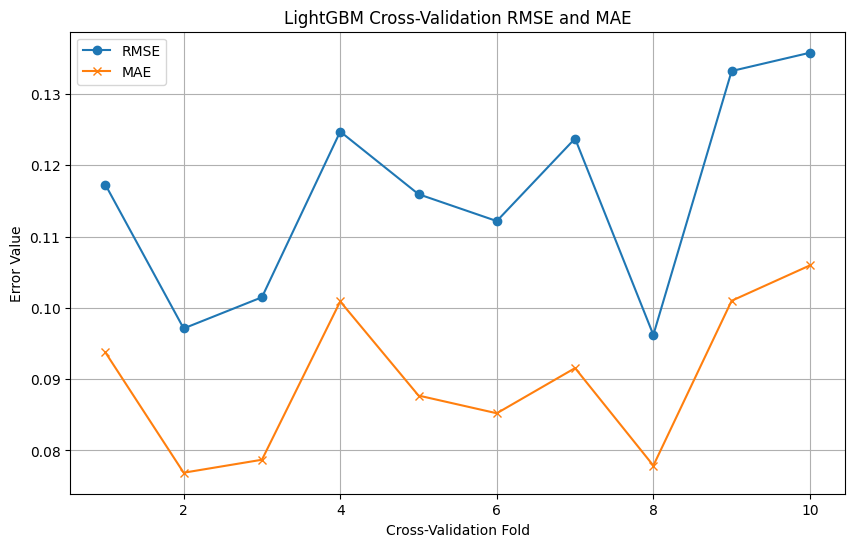

In [60]:
# Plot RMSE and MAE for each fold
folds = range(1, 11)  # Number of folds
plt.figure(figsize=(10, 6))

# Assuming rmse_scores_lgb and mae_scores_lgb are from your cross-validation
rmse_values = np.sqrt(-rmse_scores_lgb) # Calculate RMSE values
mae_values = -mae_scores_lgb  # Calculate MAE values

plt.plot(folds, rmse_values, marker='o', label='RMSE')
plt.plot(folds, mae_values, marker='x', label='MAE')

# Customize plot
plt.title('LightGBM Cross-Validation RMSE and MAE')
plt.xlabel('Cross-Validation Fold')
plt.ylabel('Error Value')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

FINAL LIGHTGBM MODEL EVALUATION ON TEST SET

In [26]:
# LightGBM Predictions
lgb_predictions = model.predict(X_test_processed, num_iteration=model.best_iteration)  # Use 'model' instead of 'lgb_model'

# Evaluate LightGBM
lgb_rmse_test = np.sqrt(mean_squared_error(y_test, lgb_predictions))
lgb_mae_test = mean_absolute_error(y_test, lgb_predictions)
print("LightGBM Test RMSE:", lgb_rmse_test)
print("LightGBM Test MAE:", lgb_mae_test)

LightGBM Test RMSE: 0.10527611047644582
LightGBM Test MAE: 0.08157782854133423


#IMPLEMENT LIGHTGBM (NON-DISTRIBUTED)

In [54]:
# Split the data into train, validation, and test sets
#X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)  # 70% train, 30% temp
#X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # 15% valid, 15% test

X_train_processed = pipeline.fit_transform(X_train)
X_test_processed = pipeline.transform(X_test)
# Prepare LightGBM datasets
X_valid_processed = pipeline.transform(X_valid)
valid_data = lgb.Dataset(X_valid_processed, label=y_valid)


# Parameters
params = {
    'objective': 'regression',
    'metric': 'rmse',  # Metric for LightGBM
    'boosting_type': 'gbdt',
    'learning_rate': 0.02805795401088166,
    'num_leaves': 25,
    'max_depth': 3,
    'verbose': -1,
    'colsample_bytree': 0.8607324052224274,
    'min_child_samples': 18,
    'n_estimators': 223,
    'subsample': 0.9087438420372645,
    'feature_pre_filter': False
}

# Create train_data after defining params with feature_pre_filter
train_data = lgb.Dataset(X_train_processed, label=y_train, params=params) # Pass params to the Dataset constructor
valid_data = lgb.Dataset(X_valid_processed, label=y_valid, params=params)  # Pass params to the Dataset constructor as well

# Initialize an empty dictionary to store evaluation results
evals_result = {}

# Train the model
print("Training LightGBM in non-distributed mode...")
model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, valid_data],
    num_boost_round=1000,
    callbacks=[
        lgb.record_evaluation(evals_result),
        lgb.early_stopping(stopping_rounds=50)

        ]
)

end_train_time = time.time()
training_time = end_train_time - start_train_time

# Record the inference time
print("Running inference on test data...")
start_run_time = time.time()
y_pred = model.predict(X_valid_processed, num_iteration=model.best_iteration)
end_run_time = time.time()

running_time = end_run_time - start_run_time

# Evaluate performance
rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
mae = mean_absolute_error(y_valid, y_pred)

# Print the results
print("\n--- LightGBM Model Evaluation (Non-Distributed) ---")
print(f"Training Time: {training_time:.4f} seconds")
print(f"Running (Inference) Time: {running_time:.4f} seconds")
print(f"LightGBM (Non-Distributed)  RMSE: {rmse:.4f}")
print(f"LightGBM (Non-Distributed) MAE: {mae:.4f}")


Training LightGBM in non-distributed mode...
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[223]	training's rmse: 0.0931867	valid_1's rmse: 0.10507
Running inference on test data...

--- LightGBM Model Evaluation (Non-Distributed) ---
Training Time: 341.3053 seconds
Running (Inference) Time: 0.0010 seconds
LightGBM (Non-Distributed)  RMSE: 0.1051
LightGBM (Non-Distributed) MAE: 0.0839


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


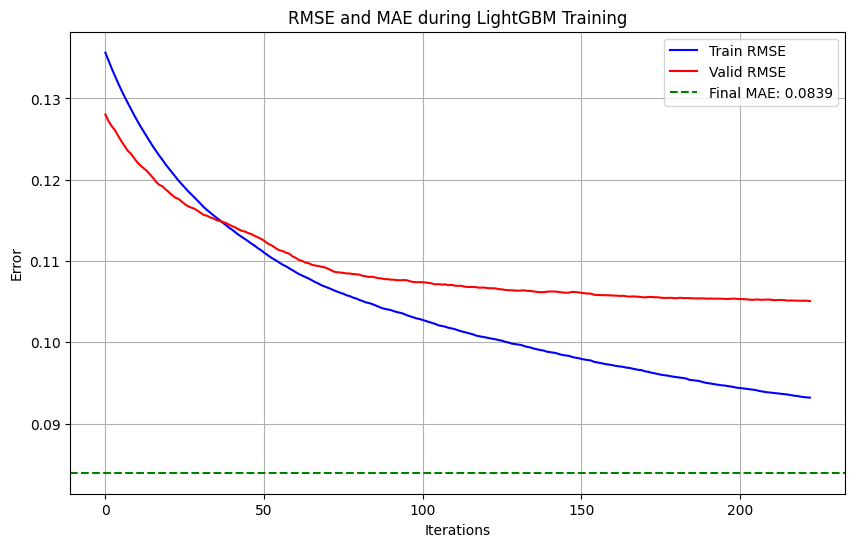

In [42]:
plt.figure(figsize=(10, 6))

# RMSE (from LightGBM metrics)
train_rmse = evals_result['training']['rmse']  # Access using 'valid_0'
valid_rmse = evals_result['valid_1']['rmse']  # Access using 'valid_0'

# Plot RMSE
plt.plot(train_rmse, label='Train RMSE', color='blue')
plt.plot(valid_rmse, label='Valid RMSE', color='red')

# Add MAE as a separate point for visualization
plt.axhline(y=mae, color='green', linestyle='--', label=f'Final MAE: {mae:.4f}')

# Labels and legend
plt.title("RMSE and MAE during LightGBM Training")
plt.xlabel("Iterations")
plt.ylabel("Error")
plt.legend()
plt.grid()
plt.show()

# Plot Training and validation Loss for lightgbm (NON-DISTRIBUTED)

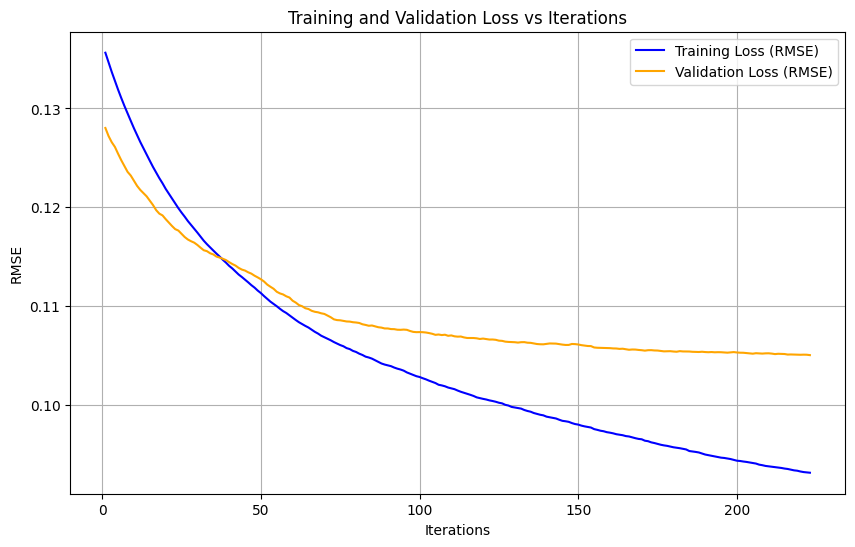

In [55]:
# Extract the metrics
train_loss = evals_result['training']['rmse']  # Training RMSE at each iteration
valid_loss = evals_result['valid_1']['rmse']  # Validation RMSE at each iteration
iterations = np.arange(len(train_loss)) + 1  # Iteration numbers (1 to num_boost_round)

# Plot Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(iterations, train_loss, label='Training Loss (RMSE)', color='blue')
plt.plot(iterations, valid_loss, label='Validation Loss (RMSE)', color='orange')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Training and Validation Loss vs Iterations')
plt.legend()
plt.grid()
plt.show()

TUNING LIGHTGBM (NON-DISTRIBUTED)

In [45]:
from scipy.stats import uniform, randint

# Initialize LightGBM model
lgb_model = lgb.LGBMRegressor(boosting_type='gbdt', objective='regression', random_state=42)

# Define the parameter distribution
param_dist = {
    'learning_rate': uniform(0.01, 0.2),
    'num_leaves': randint(20, 70),
    'max_depth': randint(3, 15),
    'n_estimators': randint(100, 1000),
    'min_child_samples': randint(10, 30),
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3)
}
# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    scoring=['neg_mean_squared_error', 'neg_mean_absolute_error'],  # Calculate both RMSE and MAE
    verbose=1,
    random_state=42,
    n_jobs=-1,
    refit='neg_mean_squared_error'  # Specify which metric to use for refitting
)

# Fit RandomizedSearchCV
X_train_processed_original = pipeline.fit_transform(X)
print("Starting Randomized Search for LightGBM...")

random_search.fit(X_train_processed_original, y)  # Use original y which is target column
# Best parameters and RMSE
best_params = random_search.best_params_
best_rmse = np.sqrt(-random_search.best_score_)

print("Best Parameters:", best_params)
print("Best RMSE:", best_rmse)


# Extract corresponding MAE for the best RMSE
results = random_search.cv_results_
best_index = random_search.best_index_
best_mae = -results['mean_test_neg_mean_absolute_error'][best_index]  # Access MAE scores
print("Corresponding MAE:", best_mae)

Starting Randomized Search for LightGBM...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'colsample_bytree': 0.8607324052224274, 'learning_rate': 0.02805795401088166, 'max_depth': 3, 'min_child_samples': 18, 'n_estimators': 223, 'num_leaves': 25, 'subsample': 0.9087438420372645}
Best RMSE: 0.12248258565988787
Corresponding MAE: 0.09670112266881771


LIGHTGBM(NON-DISTRIBUTED) CROSS-VALIDATION

In [ ]:
from sklearn.model_selection import KFold

# Prepare LightGBM Dataset
train_data = lgb.Dataset(X_train_processed, label=y_train)

# LightGBM parameters
params = {
    'objective': 'regression',
    'metric': 'rmse',  # Metric for LightGBM
    'boosting_type': 'gbdt',
    'learning_rate': 0.02805795401088166,
    'num_leaves': 25,
    'max_depth': 3,
    'verbose': -1,
    'colsample_bytree': 0.8607324052224274,
    'min_child_samples': 18,
    'n_estimators': 223,
    'subsample': 0.9087438420372645
}

# KFold Cross-Validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Initialize metrics for cross-validation
rmse_list = []
mae_list = []
training_times = []

# Cross-Validation Loop
print("Performing Cross-Validation...")
fold = 1
for train_index, valid_index in kf.split(X_train_processed):
    print(f"\nFold {fold}...")
    X_train_fold, X_valid_fold = X_train_processed[train_index], X_train_processed[valid_index]

    # Use .iloc to access data based on integer position
    y_train_fold, y_valid_fold = y_train.iloc[train_index], y_train.iloc[valid_index]

    # Create LightGBM Datasets
    train_fold_data = lgb.Dataset(X_train_fold, label=y_train_fold)
    valid_fold_data = lgb.Dataset(X_valid_fold, label=y_valid_fold)

    # Measure training time for each fold
    start_train_time = time.time()
    model = lgb.train(
    params=params,
    train_set=train_fold_data,
    num_boost_round=500,
    valid_sets=[valid_fold_data],
    callbacks=[lgb.early_stopping(stopping_rounds=50)],

)
    end_train_time = time.time()
    training_time = end_train_time - start_train_time

    # Store training time
    training_times.append(training_time)

    # Predict on the validation set
    y_pred = model.predict(X_valid_fold, num_iteration=model.best_iteration)

    # Evaluate RMSE and MAE
    rmse = np.sqrt(mean_squared_error(y_valid_fold, y_pred))
    mae = mean_absolute_error(y_valid_fold, y_pred)

    rmse_list.append(rmse)
    mae_list.append(mae)

    print(f"Fold {fold} RMSE: {rmse:.4f}, MAE: {mae:.4f}, Training Time: {training_time:.4f} seconds")
    fold += 1

# Cross-Validation Results
print("\n--- Cross-Validation Results ---")
print(f"Average RMSE: {np.mean(rmse_list):.4f} ± {np.std(rmse_list):.4f}")
print(f"Average MAE: {np.mean(mae_list):.4f} ± {np.std(mae_list):.4f}")

Performing Cross-Validation...

Fold 1...
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[223]	valid_0's rmse: 0.125528
Fold 1 RMSE: 0.1255, MAE: 0.0992, Training Time: 0.0793 seconds

Fold 2...
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[217]	valid_0's rmse: 0.114761
Fold 2 RMSE: 0.1148, MAE: 0.0900, Training Time: 0.0774 seconds

Fold 3...
Training until validation scores don't improve for 50 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[214]	valid_0's rmse: 0.114159
Fold 3 RMSE: 0.1142, MAE: 0.0920, Training Time: 0.0874 seconds

Fold 4...
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[215]	valid_0's rmse: 0.101295
Fold 4 RMSE: 0.1013, MAE: 0.0796, Training Time: 0.0936 seconds

Fold 5...
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[223]	valid_0's rmse: 0.112485
Fold 5 RMSE: 0.1125, MAE: 0.0865, Training Time: 0.0754 seconds

--- Cross-Validation Results ---
Average RMSE: 0.1136 ± 0.0077
Average MAE: 0.0895 ± 0.0065


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


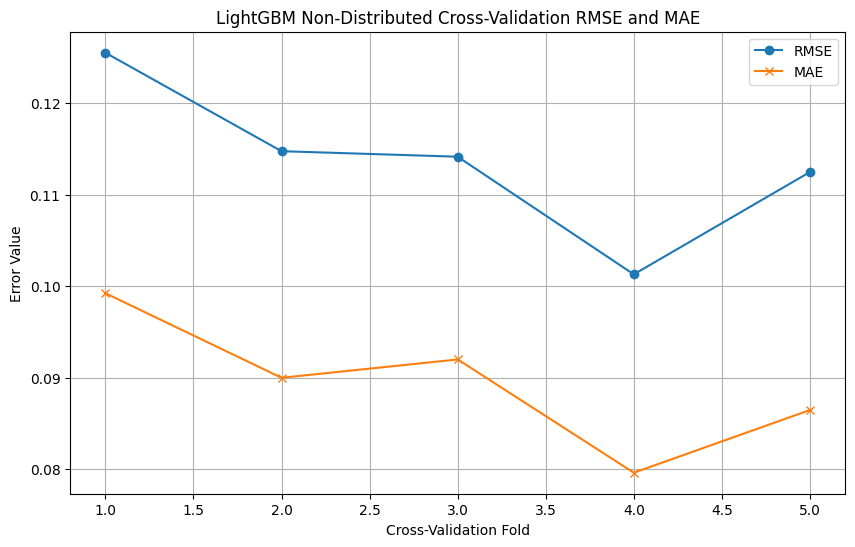

In [63]:
# Number of Cross-Validation Folds
folds = range(1, 6)  # Assuming 5-fold CV based on the previous cell's KFold

# Plot RMSE and MAE (Using rmse_list and mae_list from previous cell)
plt.figure(figsize=(10, 6))

# Assuming rmse_list and mae_list are from the previous cell (cell 56)
plt.plot(folds, rmse_list, marker='o', label='RMSE')
plt.plot(folds, mae_list, marker='x', label='MAE')

# Customize Plot
plt.title('LightGBM Non-Distributed Cross-Validation RMSE and MAE')
plt.xlabel('Cross-Validation Fold')
plt.ylabel('Error Value')
plt.legend()
plt.grid(True)

# Show Plot
plt.show()

#FINAL EVALUATION OF LIGHTGBM(NON-DISTRIBUTED)

In [57]:
# Predict on the test set using the best iteration
y_test_pred = model.predict(X_test_processed, num_iteration=model.best_iteration) # Use the correct X_test_processed

# Calculate RMSE and MAE for the test set
rmse_lgb_non = np.sqrt(mean_squared_error(y_test, y_test_pred)) #  y_test should remain the same
mae_lgb_non = mean_absolute_error(y_test, y_test_pred)

# Print final results
print("Final Model Evaluation on Test Set:")
print(f"LightGBM (Non-Distributed) TestTest RMSE: {rmse_lgb_non:.4f}")
print(f"LightGBM (Non-Distributed)Test MAE: { mae_lgb_non:.4f}")

Final Model Evaluation on Test Set:
LightGBM (Non-Distributed) TestTest RMSE: 0.1023
LightGBM (Non-Distributed)Test MAE: 0.0804


#3 MODELS COMPARISON

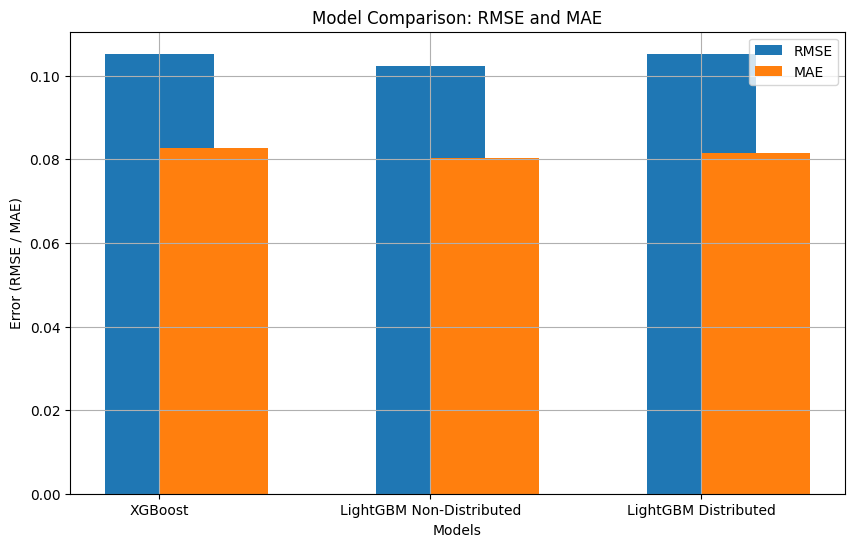

In [58]:
models = ['XGBoost', 'LightGBM Non-Distributed', 'LightGBM Distributed']
rmse_values = [rmse_xgb, rmse_lgb_non, lgb_rmse_test]
mae_values = [mae_xgb, mae_lgb_non, lgb_mae_test]

x = range(len(models))

plt.figure(figsize=(10, 6))
plt.bar(x, rmse_values, width=0.4, label='RMSE', align='center')
plt.bar(x, mae_values, width=0.4, label='MAE', align='edge')

plt.xlabel('Models')
plt.ylabel('Error (RMSE / MAE)')
plt.title('Model Comparison: RMSE and MAE')
plt.xticks(x, models)
plt.legend()
plt.grid(True)
plt.show()